In [1]:
# Custom utils
from potsdam_utils import *

# Torch Model imports
from torchvision.models.segmentation import fcn_resnet50, FCN_ResNet50_Weights
import torch.optim as optim
import torch.nn as nn


In [2]:
# Load config file and get potsdam data path
import yaml
config_path = '/home/tu/tu_tu/tu_zxmav84/DS_Project/modules/config.yml'
with open(config_path, 'r') as f:
    config = yaml.load(f, Loader=yaml.FullLoader)
path = config['data']['potsdam']

### DataSet and DataLoader

In [3]:
file_paths = get_file_paths()
print('Example 0 in file paths:')
file_paths[0]

Indexing files in potsdam/Patched... 
Found: 	 342 Images 
	 342 Mask
Example 0 in file paths:


('/pfs/work7/workspace/scratch/tu_zxmav84-ds_project/data/potsdam/Patched/top_potsdam_2_11_patch_2_2_image.tif',
 '/pfs/work7/workspace/scratch/tu_zxmav84-ds_project/data/potsdam/Patched/top_potsdam_2_11_patch_2_2_mask.tif')

In [4]:
train_dict, test_dict = train_test_split(file_paths, test_size=0.2)
BATCH_SIZE = 8
train_loader = DataLoader(PotsdamDataset(train_dict, transform=train_transform), 
                          batch_size = BATCH_SIZE, 
                          num_workers = 2)
test_loader = DataLoader(PotsdamDataset(test_dict, transform=test_transform),
                          batch_size = BATCH_SIZE, 
                          num_workers = 2)
print(f"Length of train loader: {len(train_loader)}; Length of test loader: {len(test_loader)} with batch size {BATCH_SIZE}")

Length of all files: 333
Length of train (266) and test (67): 333
Length of train loader: 34; Length of test loader: 9 with batch size 8


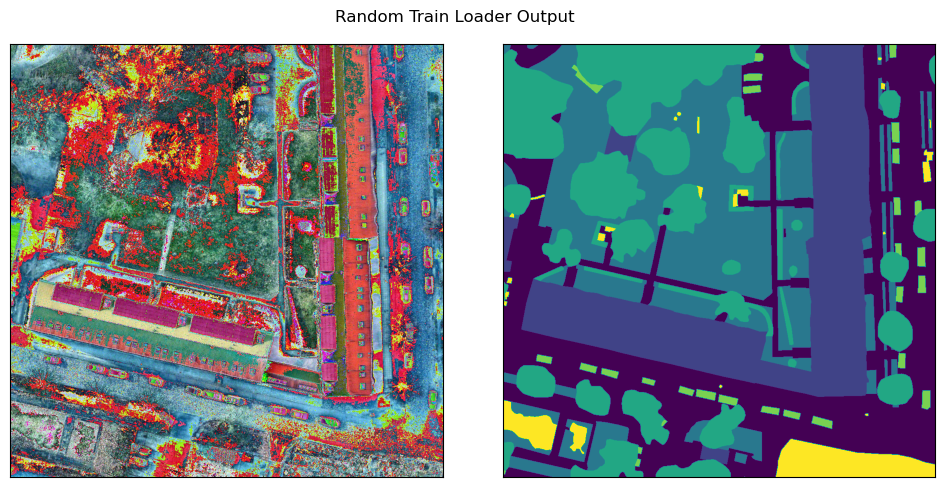

In [5]:
data = next(iter(train_loader))
idx = random.randint(0, data[0].shape[0]-1)
img = data[0][idx]
mask = data[1][idx]
plot_example(ToPILImage()(img), 
             ToPILImage()(mask), 
             title='Random Train Loader Output', 
             plot_legend=False)

### Model setup

In [6]:
def calculate_accuracy(model):
    print("\nEvaluating Accuracy on Test Set...")
    correct_pixels = 0
    num_pixels = 0

    model.eval()
    with torch.no_grad():
        for data, label in test_loader:
            data = data.to(DEVICE)
            logits = model(data)['out']
            prob = nn.Softmax(logits).dim
            pred = torch.argmax(prob, dim = 1)
            correct_pixels += (pred.cpu() == label).sum()
            num_pixels += pred.numel()
        print(f"\n\tAccuracy: {np.round((correct_pixels/num_pixels)*100,2)}")


In [7]:
def train_epoch():
    model.train()
    loss_sum = 0
    for batch_id, (data, label) in enumerate(train_loader):
        # Send data and label to DEVICE
        data = data.to(DEVICE)
        label = label.to(DEVICE)

        # Forward Pass:
        output = model(data)['out']

        # Caluclate Loss
        loss = LOSS_FUNC(output, label.long())

        # Backward Pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Comupte loss sum and count batches
        loss_sum += loss.item()
        batch_id += 1

        if batch_id%5==0:
            print(f'Epoch: {epoch} | Batch {batch_id} / {len(train_loader)} | Loss: {np.round(loss_sum/(batch_id),4)}')

In [8]:
# Device setup
if torch.cuda.is_available():
    DEVICE = 'cuda'
elif torch.backends.mps.is_available():
    DEVICE = 'mps'
else:
    DEVICE = 'cpu'
print(f"Using {DEVICE} as DEVICE")

Using cuda as DEVICE


In [9]:
# Hyperparameters
NUM_CLASSES = 6

# Training Parameters
NUM_EPOCHS = 3
LEARNING_RATE = 0.5
FROZEN = True
AUX_LAYER = True


In [10]:
# Model specification
weights = FCN_ResNet50_Weights.DEFAULT # Default uses pretrained weights on COCO
model = fcn_resnet50(weights=weights)
if FROZEN: # freeze all weights except last layer, i.e. clasification head
    for layer_name, param in model.named_parameters():
        if 'classifier' not in layer_name:
            param.requires_grad = False

# Change output dimension of the net to different dimentsion to facilitate number of classes
model.classifier[4] = nn.Conv2d(512, NUM_CLASSES, kernel_size=(1, 1))
model.aux_classifier[4] = nn.Conv2d(256, NUM_CLASSES, kernel_size=(1, 1))

# Remove aux classifier if specified
if not AUX_LAYER:
    model.aux_classifier = None

# Send model to DEVICE
model = model.to(DEVICE)    

# Optimization setup
optimizer = optim.SGD(params=model.parameters(), lr=LEARNING_RATE)
LOSS_FUNC = nn.CrossEntropyLoss()



In [11]:
calculate_accuracy(model)
for epoch in range(NUM_EPOCHS):
    train_epoch()
    calculate_accuracy(model)



Evaluating Accuracy on Test Set...

	Accuracy: 7.349999904632568
Epoch: 0 | Batch 5 / 34 | Loss: 1.6479
Epoch: 0 | Batch 10 / 34 | Loss: 1.472
Epoch: 0 | Batch 15 / 34 | Loss: 1.4265
Epoch: 0 | Batch 20 / 34 | Loss: 1.3363
Epoch: 0 | Batch 25 / 34 | Loss: 1.2955
Epoch: 0 | Batch 30 / 34 | Loss: 1.2719

Evaluating Accuracy on Test Set...

	Accuracy: 58.95000076293945
Epoch: 1 | Batch 5 / 34 | Loss: 0.9339
Epoch: 1 | Batch 10 / 34 | Loss: 0.9231
Epoch: 1 | Batch 15 / 34 | Loss: 0.9388
Epoch: 1 | Batch 20 / 34 | Loss: 0.9215
Epoch: 1 | Batch 25 / 34 | Loss: 0.928
Epoch: 1 | Batch 30 / 34 | Loss: 0.9373

Evaluating Accuracy on Test Set...

	Accuracy: 59.099998474121094
Epoch: 2 | Batch 5 / 34 | Loss: 0.8689
Epoch: 2 | Batch 10 / 34 | Loss: 0.8631
Epoch: 2 | Batch 15 / 34 | Loss: 0.8813
Epoch: 2 | Batch 20 / 34 | Loss: 0.8643
Epoch: 2 | Batch 25 / 34 | Loss: 0.8724
Epoch: 2 | Batch 30 / 34 | Loss: 0.8838

Evaluating Accuracy on Test Set...

	Accuracy: 65.5199966430664


In [12]:
# Save model to disk
torch.save(model, config['data']['potsdam']+'/weights/potsdam_FCN.pth.tar')
torch.save(optimizer, config['data']['potsdam']+'/weights/potsdam_FCN_optim.pth.tar')

### Evaluate the Model 

In [13]:
# Load the model
model = torch.load(config['data']['potsdam']+'/weights/potsdam_FCN.pth.tar')
optimizer = torch.load(config['data']['potsdam']+'/weights/potsdam_FCN_optim.pth.tar')

In [14]:
# Get all images, targets and predictions for the test set
all_images = np.zeros([BATCH_SIZE*(len(test_loader)-1), 3, 1000, 1000])
all_labels = np.zeros([BATCH_SIZE*(len(test_loader)-1), 1000, 1000])
all_predictions = np.zeros([BATCH_SIZE*(len(test_loader)-1), 1000, 1000])

for idx, (data, label) in enumerate(test_loader):
    print(f"Processing batch {idx} of {len(test_loader)-1}")
    if idx != len(test_loader)-1:
        all_images[idx*BATCH_SIZE:((idx+1)*BATCH_SIZE), :, :, :] = data
        all_labels[idx*BATCH_SIZE:((idx+1)*BATCH_SIZE), :, :] = label

        # Get model predictions and save them
        model.eval()
        with torch.no_grad():
            data = data.to(DEVICE)
            logits = model(data)['out']
            prob = nn.Softmax(logits).dim
            pred = torch.argmax(prob, dim = 1)
        all_predictions[idx*BATCH_SIZE:((idx+1)*BATCH_SIZE), :, :] = pred.cpu()

Processing batch 0 of 8
Processing batch 1 of 8
Processing batch 2 of 8
Processing batch 3 of 8
Processing batch 4 of 8
Processing batch 5 of 8
Processing batch 6 of 8
Processing batch 7 of 8
Processing batch 8 of 8


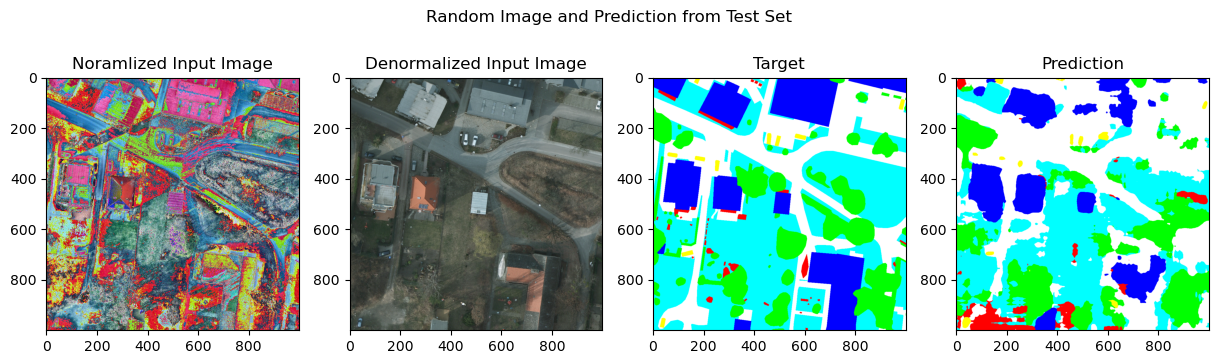

In [15]:
# Plot random instance of the test set
idx = random.randint(0, all_images.shape[0])
img = all_images[idx,:,:,:]
label = all_labels[idx,:,:]
prediction = all_predictions[idx, :, :]

fig, ax = plt.subplots(1,4, figsize = (15,4))
ax[0].imshow(ToPILImage()(torch.from_numpy(img)))
ax[0].set_title('Noramlized Input Image')
ax[1].imshow(ToPILImage()(torch.from_numpy(denormalize_image(img))))
ax[1].set_title('Denormalized Input Image')
ax[2].imshow(map_label2rgb(label))
ax[2].set_title('Target')
ax[3].imshow(map_label2rgb(prediction))
ax[3].set_title('Prediction')
plt.suptitle('Random Image and Prediction from Test Set')
plt.show()